In [1]:
import os
from ultralytics import YOLO
from ultralytics.utils.metrics import ConfusionMatrix, box_iou
import torch
import time
from pathlib import Path
import numpy as np
from tqdm import tqdm
import yaml
import psutil
import GPUtil
import cv2
from matplotlib import pyplot as plt

%cd FallDetection
print(torch.cuda.is_available())
print(torch.cuda.device_count())

[WinError 2] The system cannot find the file specified: 'FallDetection'
D:\Code\PyCharm\MLEnv\FallDetection\Fall-Detection
False
0


In [ ]:
torch.cuda.set_device('cuda:0')

In [ ]:
class HumanDetectionTrainer:
    def __init__(self, data_folder, project_name="human_detection"):
        self.project_name = project_name
        self.best_val_map = 0
        self.data_folder = data_folder
        self.data_yaml = data_folder + '/data.yaml'

        # Create project directory
        os.makedirs(project_name, exist_ok=True)

    def train(self, idx, hp):
            model = YOLO(hp['model'])

            # Update training arguments
            train_args = {
                'data': self.data_yaml,
                'epochs': 100,
                'imgsz': hp['imgsz'],
                'freeze': hp['freeze'],
                'cos_lr': hp['cos_lr'],
                'patience': 5,
                'lr0': hp['lr0'],
                'optimizer': hp['optimizer'],
                'project': self.project_name,
                'save_period': 5,
                'name': f'run_{idx}',
                'device': 0
            }
            
            if hp['lr0'] == None:
                del train_args['lr0']
            
            cpu_percent = psutil.Process().memory_info().rss / 1024 / 1024  # MB
            if torch.cuda.is_available():
                gpu = GPUtil.getGPUs()[0]
                gpu_percent = gpu.memoryUsed

            # Train the model
            results = model.train(**train_args)
            
            # Record metrics
            gpu_usage = max(gpu_percent, GPUtil.getGPUs()[0].memoryUsed) if torch.cuda.is_available() else 0
            print('CPU usage:', cpu_percent)
            print('GPU usage:', gpu_usage)
            
    
    def inference_evaluation(self, hp, test_data_path='/test/images', batch_size=16, model_cp='yolov8l.pt'):
        test_data_path = self.data_folder + test_data_path
        model = YOLO(model_cp)

        inference_times = []
        cpu_usage = []
        gpu_usage = []
        map_50_95 = []
        mar_50_95 = []
        pred_boxes = {}

        image_files = list(Path(test_data_path).glob('*.jpg')) + list(Path(test_data_path).glob('*.png'))
        if not image_files:
            raise ValueError(f"No images found in {test_data_path}")
            
        for i in tqdm(range(0, len(image_files), batch_size), desc="Processing images"):
            batch_files = image_files[i:i + batch_size]
            start_time = time.time()

            # Record CPU and GPU usage before inference
            cpu_percent = psutil.Process().memory_info().rss / 1024 / 1024  # MB
            if torch.cuda.is_available():
                gpu = GPUtil.getGPUs()[0]
                gpu_percent = gpu.memoryUsed

            results = model.predict(batch_files, imgsz=hp['imgsz'], conf=hp['conf'], iou=hp['iou'], device=0, verbose=False)

            inference_times.append((time.time() - start_time) / len(batch_files))
            cpu_usage.append(cpu_percent)
            if torch.cuda.is_available():
                gpu_usage.append(gpu_percent)
                
            for img_path, result in zip(batch_files, results):
                img_height, img_width = result.orig_shape
                boxes = self.convert_to_roboflow_format(result, img_width, img_height)
                pred_boxes[img_path.stem] = boxes

        mean_ap, mean_ar = self.evaluate_predictions(pred_boxes, self.data_folder + '/test/labels')
        metrics_report = {
            'total_images_processed': len(image_files),
            'avg_speed_per_image': np.mean(inference_times),
            'max_cpu_ram_mb': max(cpu_usage),
            'max_gpu_ram_mb': max(gpu_usage) if torch.cuda.is_available() else None,
            'mean_map_50_95': mean_ap,
            'mean_mar_50_95': mean_ar
        }
        return metrics_report
    
    def convert_to_roboflow_format(self, prediction, image_width, image_height):
        """
        Convert YOLOv8 predictions to Roboflow format
        Roboflow format: <class> <x_center> <y_center> <width> <height> <confidence>
        All coordinates are normalized [0-1]
        For human detection, class is always 0
        """
        boxes = []
        if prediction.boxes is not None and len(prediction.boxes) > 0:
            for box in prediction.boxes:
                # Get box coordinates (in pixel coordinates)
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                confidence = box.conf[0].cpu().numpy()
                CLS = box.cls

                # Convert to center coordinates and normalize
                x_center = ((x1 + x2) / 2) / image_width
                y_center = ((y1 + y2) / 2) / image_height
                width = (x2 - x1) / image_width
                height = (y2 - y1) / image_height

                # Format: class x_center y_center width height confidence
                # Class 0 for human
                if CLS == 0:
                    box = (x_center, y_center, width, height)
                    boxes.append(box)
        return boxes
    
    def evaluate_predictions(self, predictions, gt_dir):
        iou_thresholds = np.arange(0.5, 1.0, 0.05)
        ap_values = []
        ar_values = []
        accuracy_values = []
        f1_values = []
        for iou_thresh in iou_thresholds:
            tp = fp = fn = 0
            for fname in predictions.keys():
                file_path = os.path.join(gt_dir, fname) + '.txt'
                with open(file_path, 'r', encoding='utf-8') as f:
                    gt_boxes = [line.strip().split() for line in f.readlines()]
                if gt_boxes:
                    gt_boxes = np.array([[float(x) for x in box[1:5]] for box in gt_boxes])
                else:
                    gt_boxes = np.zeros((0, 4))
                pred_boxes = predictions.get(fname, [])
                pred_boxes = np.array([[float(x) for x in box] for box in pred_boxes])
                #print(fname)
                #print('PRED', pred_boxes)
                #print('GOLD', gt_boxes)

                # Convert to corner format for IoU calculation
                def center_to_corners(boxes):
                    if len(boxes) == 0:
                        return boxes
                    x_center, y_center, width, height = boxes.T
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2
                    x2 = x_center + width / 2
                    y2 = y_center + height / 2
                    return np.stack((x1, y1, x2, y2), axis=1)

                pred_corners = center_to_corners(pred_boxes)
                gt_corners = center_to_corners(gt_boxes)

                # Calculate IoU matrix
                if len(pred_corners) > 0 and len(gt_corners) > 0:
                    iou_matrix = box_iou(
                        torch.tensor(pred_corners),
                        torch.tensor(gt_corners)
                    ).numpy()

                    # Match predictions to ground truths
                    matched = iou_matrix >= iou_thresh

                    tp += np.sum(matched.any(axis=1))  # True positives
                    fp += len(pred_boxes) - np.sum(matched.any(axis=1))  # False positives
                    fn += len(gt_boxes) - np.sum(matched.any(axis=0))  # False negatives
                else:
                    fp += len(pred_boxes)
                    fn += len(gt_boxes)

            # Calculate precision and recall
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            ap_values.append(precision)
            ar_values.append(recall)
            accuracy_values.append(accuracy)
            f1_values.append(f1_score)


        # Calculate mean values
        mean_ap = np.mean(ap_values)
        mean_ar = np.mean(ar_values)
        mean_accuracy = np.mean(accuracy_values)
        mean_f1_score = np.mean(f1_values)

        return mean_ap, mean_ar, mean_accuracy, mean_f1_score
    
    def detect_objects(self, image_path, hp, model_cp='yolov8l.pt'):
            """
            Phương thức nhận diện đối tượng trong một ảnh duy nhất.
            Trả về kết quả dự đoán của mô hình.
            """
            model = YOLO(model_cp)
            preprocessed_image = optimize_quality_enhancement(image_path)  # Tối ưu hóa chất lượng ảnh nếu cần
            results = model.predict(preprocessed_image, imgsz=hp['imgsz'], conf=hp['conf'], iou=hp['iou'], device=0, verbose=False)  # Dự đoán
            return results[0]
    
    def show_detection_results(self, image_path, results):
        """
        Phương thức hiển thị ảnh cùng với bounding boxes từ kết quả nhận diện.
        Chỉ hiển thị bounding boxes cho lớp 0 (Human).
        """
        # Đọc ảnh
        image = cv2.imread(image_path)
        img_height, img_width = image.shape[:2]  # Lấy kích thước ảnh gốc
        
        # Chuyển từ BGR sang RGB để hiển thị trong Matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        # Duyệt qua từng bounding box trong kết quả
        for box in results.boxes:
            # Lấy tọa độ trung tâm và kích thước (tọa độ chuẩn hóa từ mô hình YOLO)
            x_center, y_center, w, h = box.xywhn[0].cpu().numpy()  # `.xywhn` trả về tọa độ chuẩn hóa
            
            # Lấy độ tin cậy và nhãn lớp
            confidence = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())  # Lấy chỉ số lớp (class index)
            
            # Chỉ vẽ bounding box cho lớp 0 (Human)
            if cls == 0:
                # Chuyển đổi từ tọa độ chuẩn hóa sang tọa độ pixel
                x1 = int((x_center - w / 2) * img_width)
                y1 = int((y_center - h / 2) * img_height)
                x2 = int((x_center + w / 2) * img_width)
                y2 = int((y_center + h / 2) * img_height)
    
                # Tạo nhãn cho lớp Human với confidence
                label = f"Human: {confidence:.2f}"
    
                # Vẽ bounding box và nhãn lên ảnh
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Hộp màu xanh
                cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        # Hiển thị ảnh
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis("off")
        plt.show()

In [ ]:
def extract_frames(video_path, output_folder):
    # Kiểm tra xem thư mục output có tồn tại không, nếu không thì tạo
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Mở video bằng OpenCV
    cap = cv2.VideoCapture(video_path)
    # Kiểm tra xem video có được mở thành công không
    if not cap.isOpened():
        print("Không thể mở video.")
        return
    # Đếm số frame
    frame_count = 0
    while True:
        # Đọc frame tiếp theo
        ret, frame = cap.read()
        # Nếu không còn frame nào thì thoát
        if not ret:
            break
        # Đặt tên cho từng frame và lưu chúng vào thư mục
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        frame_count += 1
    # Giải phóng tài nguyên
    cap.release()
    print(f"Đã tách xong video thành {frame_count} frame.")

def extract_frames_from_multiple_videos(input_folder, output_folder):
    # Kiểm tra thư mục đầu ra có tồn tại không, nếu không thì tạo
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Lấy danh sách các file trong thư mục đầu vào
    video_files = [f for f in os.listdir(input_folder) if f.endswith(('.mp4', '.avi', '.mkv'))]
    for video_file in video_files:
        #print(video_file)
        # Đường dẫn đầy đủ tới video
        video_path = os.path.join(input_folder, video_file)
        # Tạo một thư mục riêng cho từng video để chứa các frame
        video_output_folder = os.path.join(output_folder, os.path.splitext(video_file)[0])
        if not os.path.exists(video_output_folder):
            os.makedirs(video_output_folder)
        # Gọi hàm extract_frames để tách frame từ video này
        extract_frames(video_path, video_output_folder)

In [ ]:
def optimize_quality_enhancement(image_path, filter_type='gaussian', kernel_size=5, equalize_hist=False):
    """
    Tối ưu hóa độ sáng và độ tương phản cho hình ảnh để đạt chất lượng tốt nhất dựa trên PSNR.
    Tham số:
    - image_path: Đường dẫn đến hình ảnh.
    Trả về:
    - best_image: Hình ảnh sau khi áp dụng độ sáng và độ tương phản tối ưu.
    - best_params: Bộ tham số độ sáng và độ tương phản tốt nhất.
    """
    # Đọc ảnh gốc
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError("Không thể tải hình ảnh. Vui lòng kiểm tra đường dẫn.")
    # điều chỉnh độ sáng và tương phản 
    # Đặt các giá trị độ sáng và độ tương phản mong muốn
    brightness = 30  # Điều chỉnh độ sáng (-50 đến 50)
    contrast = 20    # Điều chỉnh độ tương phản (-50 đến 50)
    # Áp dụng điều chỉnh độ sáng và độ tương phản
    best_image = cv2.convertScaleAbs(original, alpha=1 + contrast / 127.0, beta=brightness)
    # Áp dụng bộ lọc giảm nhiễu
    if filter_type == 'gaussian':
        best_image = cv2.GaussianBlur(best_image, (kernel_size, kernel_size), 0)
    elif filter_type == 'median':
        best_image = cv2.medianBlur(best_image, kernel_size)
    else:
        raise ValueError("Loại bộ lọc không hợp lệ. Chọn 'gaussian' hoặc 'median'.")
    # Cân bằng histogram nếu cần
    if equalize_hist:
    # Khởi tạo CLAHE với các tham số tùy chỉnh
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        if len(best_image.shape) == 2:  # Ảnh grayscale. Nếu ảnh là grayscale, CLAHE được áp dụng trực tiếp
            best_image = clahe.apply(best_image)
        else:
            # Cân bằng histogram CLAHE chỉ trên kênh Y (độ sáng) trong không gian YCrCb
            ycrcb = cv2.cvtColor(best_image, cv2.COLOR_BGR2YCrCb)
            y_channel, cr, cb = cv2.split(ycrcb)
            # Áp dụng CLAHE trên kênh Y
            y_channel = clahe.apply(y_channel)
            # Ghép lại các kênh sau khi cân bằng
            ycrcb_clahe = cv2.merge((y_channel, cr, cb))
            best_image = cv2.cvtColor(ycrcb_clahe, cv2.COLOR_YCrCb2BGR)
            # Chuyển ảnh sang không gian màu YCrCb, sau đó chỉ áp dụng CLAHE lên kênh Y (độ sáng), để giữ màu sắc tự nhiên. Sau đó chuyển ảnh về không gian BGR để hiển thị
    return best_image

def display_optimized_image(image_path):
     # Đọc ảnh gốc
    original_image = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB để hiển thị
    # Tối ưu hóa độ sáng và độ tương phản
    best_image = optimize_quality_enhancement(image_path)
    # Chuyển đổi BGR sang RGB để hiển thị
    best_image_rgb = cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB)
    # Hiển thị ảnh gốc và ảnh tối ưu
    plt.figure(figsize=(12, 6))
    # Hiển thị ảnh gốc
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_rgb)
    plt.axis("off")
    plt.title("Ảnh gốc")
    # Hiển thị ảnh tối ưu hóa
    plt.subplot(1, 2, 2)
    plt.imshow(best_image_rgb)
    plt.axis("off")
    plt.title("Ảnh tối ưu")
    plt.show()

In [3]:
def showResult(fname, boxes):
    img = cv2.imread('dataset/Person_detection/test/images/' + fname + '.jpg')
    height, width = img.shape[:2]

    # Draw boxes
    for box in boxes:
        # Convert from x_center, y_center, width, height to x1,y1,x2,y2
        x_center, y_center = box[0], box[1]
        w, h = box[2], box[3]

        # Convert normalized coordinates to pixel coordinates
        x1 = int((x_center - w/2) * width)
        y1 = int((y_center - h/2) * height)
        x2 = int((x_center + w/2) * width)
        y2 = int((y_center + h/2) * height)

        # Draw rectangle
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [ ]:
# Thư mục chứa các video
input_folder = "D:/Dagoras/Fall-Detection/dataset/video"

# Thư mục chứa các thư mục frame của từng video
output_folder = "D:/Dagoras/Fall-Detection/dataset/output_frames"
extract_frames_from_multiple_videos(input_folder, output_folder)

In [3]:
trainer = HumanDetectionTrainer('dataset/Person_detection')

In [ ]:
run_name = "test"
params = {'freeze': 9, 'cos_lr': True, 'model': 'yolov8l.pt',
         'imgsz': 640, 'lr0': 0.001, 'optimizer': 'AdamW'}

trainer.train(run_name, params)

New https://pypi.org/project/ultralytics/8.3.29 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.25 🚀 Python-3.11.4 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=dataset/Person_detection/data.yaml, epochs=100, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=0, workers=8, project=human_detection, name=run_lr0_0005, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=9, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=N

train: Scanning /home/phuongmt/FallDetection/dataset/Person_detection/train/labels.cache... 1747 images, 38 backgrounds,
val: Scanning /home/phuongmt/FallDetection/dataset/Person_detection/valid/labels.cache... 256 images, 10 backgrounds, 0 


Plotting labels to human_detection/run_lr0_0005/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to human_detection/run_lr0_0005
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.96G     0.9478     0.9416      1.176         78        640: 100%|██████████| 110/110 [00:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00

                   all        256        599      0.895      0.835      0.917      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.41G      1.034     0.7934       1.22         33        640: 100%|██████████| 110/110 [01:07<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00

                   all        256        599      0.851      0.781      0.868      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.09G          1     0.7642       1.22         11        640: 100%|██████████| 110/110 [01:19<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00

                   all        256        599       0.85      0.795      0.882      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.19G      1.045     0.7834      1.215         28        640: 100%|██████████| 110/110 [01:11<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00

                   all        256        599      0.842      0.845      0.882       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.17G     0.9713     0.7281      1.187         27        640: 100%|██████████| 110/110 [01:26<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00

                   all        256        599       0.88      0.838      0.908      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       4.1G     0.9537     0.7015      1.178         14        640: 100%|██████████| 110/110 [01:33<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:19<00

                   all        256        599      0.846       0.82      0.891      0.623
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



6 epochs completed in 0.150 hours.
Optimizer stripped from human_detection/run_lr0_0005/weights/last.pt, 87.6MB
Optimizer stripped from human_detection/run_lr0_0005/weights/best.pt, 87.6MB

Validating human_detection/run_lr0_0005/weights/best.pt...
Ultralytics 8.3.25 🚀 Python-3.11.4 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
Model summary (fused): 268 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:24<00


                   all        256        599      0.895      0.835      0.917      0.648
Speed: 0.1ms preprocess, 88.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to human_detection/run_lr0_0005
CPU usage: 4658.2578125
GPU usage: 2805.0


In [4]:
hp = {'imgsz': 640, 'conf': 0.35, 'iou': 0.8}
metrics = trainer.inference_evaluation(hp, model_cp="human_detection/run_lr0_001/weights/best.pt")

print(f"\nEvaluation Results of {metrics['total_images_processed']} images:")
print(f"Average Speed per image: {metrics['avg_speed_per_image']:.2f} seconds")
print(f"Max CPU RAM: {metrics['max_cpu_ram_mb']:.2f} MB")
if metrics['max_gpu_ram_mb']:
    print(f"Max GPU RAM: {metrics['max_gpu_ram_mb']:.2f} MB")
print(f"Mean Average Precision (50-95):", [int(x*10000)/100 for x in metrics['mean_map_50_95']])
print(f"Mean Average Recall (50-95):", [int(x*10000)/100 for x in metrics['mean_mar_50_95']])

Processing images: 100%|████████████████████████████████████████████████████████████████| 34/34 [08:26<00:00, 14.90s/it]



Evaluation Results of 542 images:
Average Speed per image: 0.93 seconds
Max CPU RAM: 2244.21 MB
Max GPU RAM: 7321.00 MB
Mean Average Precision (50-95): [86.12, 83.76, 81.85, 78.88, 75.38, 68.52, 61.35, 51.44, 36.35, 15.09]
Mean Average Recall (50-95): [86.92, 85.72, 84.16, 82.01, 78.93, 72.73, 66.03, 55.78, 39.45, 16.37]


In [ ]:
fname = 'Moto_mp4-347_jpg.rf.b5d187a2966ca9923072066162c966b8'
hp = {'imgsz': 640, 'conf': 0.35, 'iou': 0.8}
# Gọi hàm detect_objects để nhận diện đối tượng trong ảnh một trong 2 dòng dưới đây
# results = trainer.detect_objects('dataset/Person_detection/test/images/' + fname + '.jpg', hp, model_cp="human_detection/run_test/weights/best.pt")
results = trainer.detect_objects('dataset/Person_detection/test/images/' + fname + '.jpg', hp)

# Hiển thị kết quả nhận diện trên ảnh với các bounding boxes
trainer.show_detection_results('dataset/Person_detection/test/images/' + fname + '.jpg', results=results)

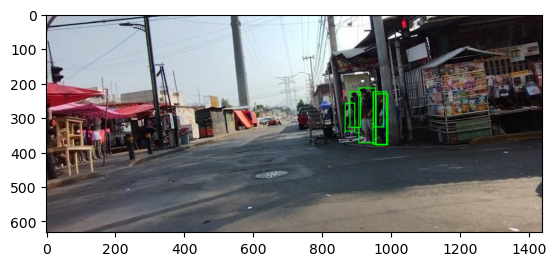

In [29]:
fname = 'Moto_mp4-347_jpg.rf.b5d187a2966ca9923072066162c966b8'
boxes_1 = np.array(
[[    0.64753   ,  0.46461  ,  0.033199   ,  0.25133],
 [    0.61262  ,   0.47297  ,  0.019566   ,  0.12917],
 [    0.62339  ,   0.43824  ,  0.021744   ,   0.1628],
 [    0.67297  ,   0.47706  ,  0.027078   ,  0.23976],
 [    0.67045  ,   0.43736  ,   0.02097  ,    0.1622],
 [    0.67768  ,   0.48364  ,  0.023728  ,   0.23395]])
boxes_2 = np.array(
[[    0.65189   ,  0.46652  ,   0.03934  ,   0.25582],
 [    0.62352   ,  0.44717  ,  0.019153  ,   0.17394]])
showResult(fname, boxes_1)

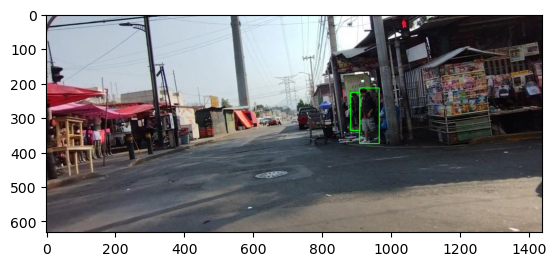

In [30]:
showResult(fname, boxes_2)

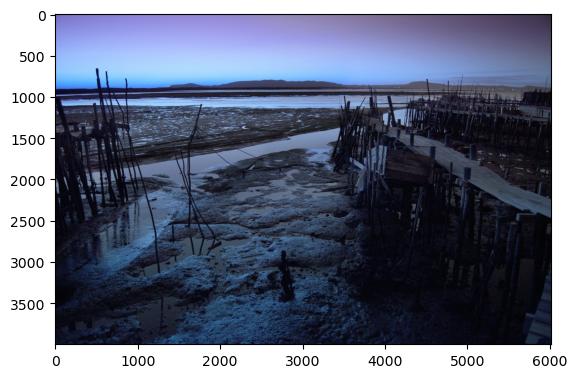

In [5]:
img = cv2.imread('D:\Code\PyCharm\MLEnv\FallDetection\dataset/Person_detection/test/images/eduardo-goody-XEFolUK5uuE-unsplash_jpg.rf.0cbe9dd83616662cd6a7076370bc09a1' + '.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)